In [1]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import lewis_tune_sim as lts
from confirm.lewislib import lewis

In [100]:
name = '3d_withsims'
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)
grid_batch_size = 2**6 if jax.devices()[0].device_kind == "cpu" else 2**10
batched_many_rej = lts.grouped_by_sim_size(lei_obj, lts.rejvv, grid_batch_size)

In [130]:
import pickle
with open(f'{name}/164.pkl', 'rb') as f:
    data = pickle.load(f)
g, sim_sizes, bootstrap_cvs, _, _, pointwise_target_alpha = data
!df -h /workspaces

Filesystem      Size  Used Avail Use% Mounted on
/dev/loop0      126G   51G   70G  43% /workspaces


In [131]:
# Configuration used during simulation
# TODO: things that should be saved in the future!!
n_arms = params['n_arms']
target_alpha = 0.025
target_grid_cost = 0.002
init_nsims = 2000
max_sim_double = 7
max_sim_size = init_nsims * 2 ** max_sim_double
seed = 0
key = jax.random.PRNGKey(seed)
unifs = jax.random.uniform(key=key, shape=(max_sim_size,) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

number of tiles near critical:  1696367
    and with loose bounds 754871
pct of sim sizes > 2000: 6.5%


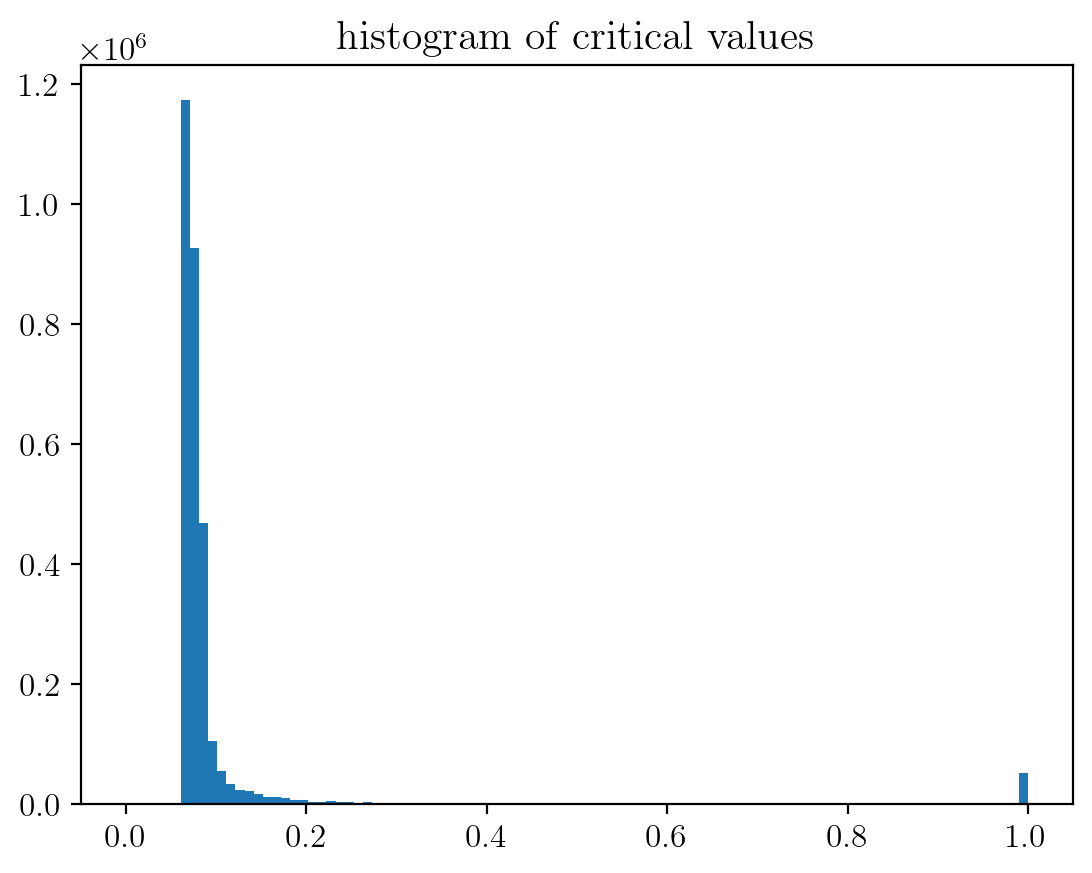

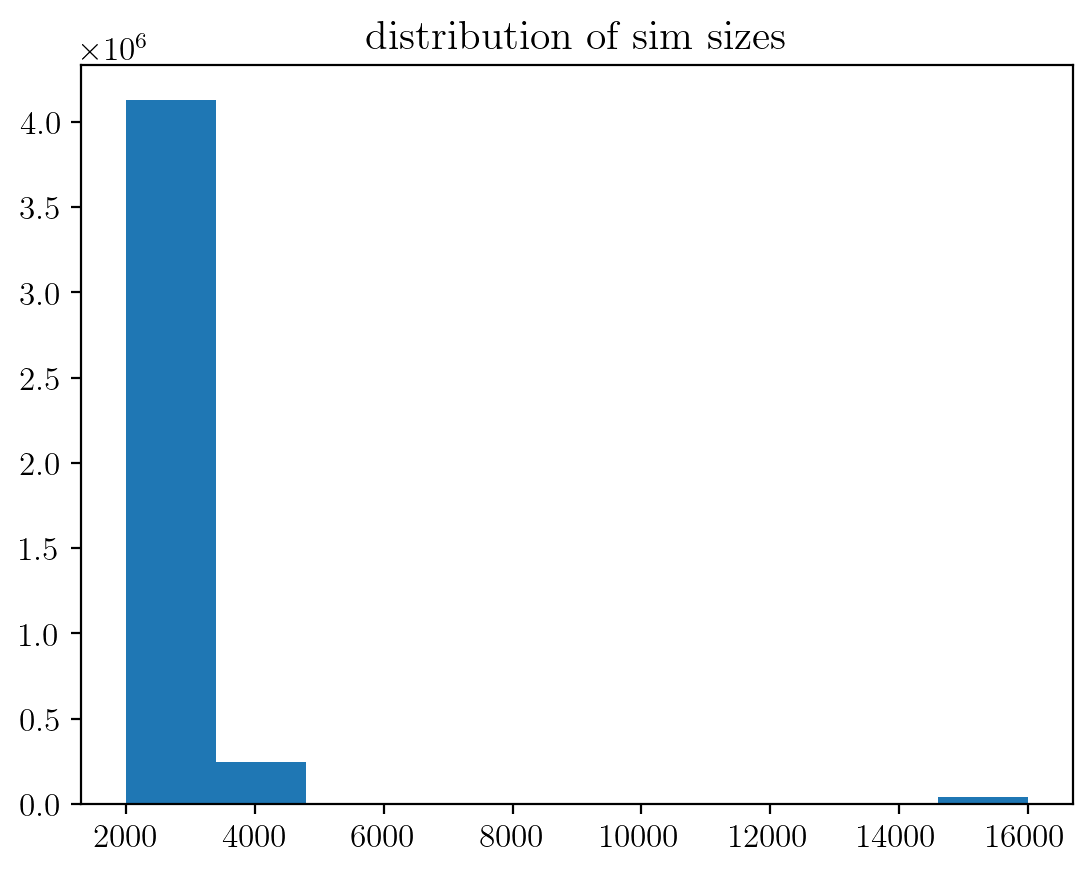

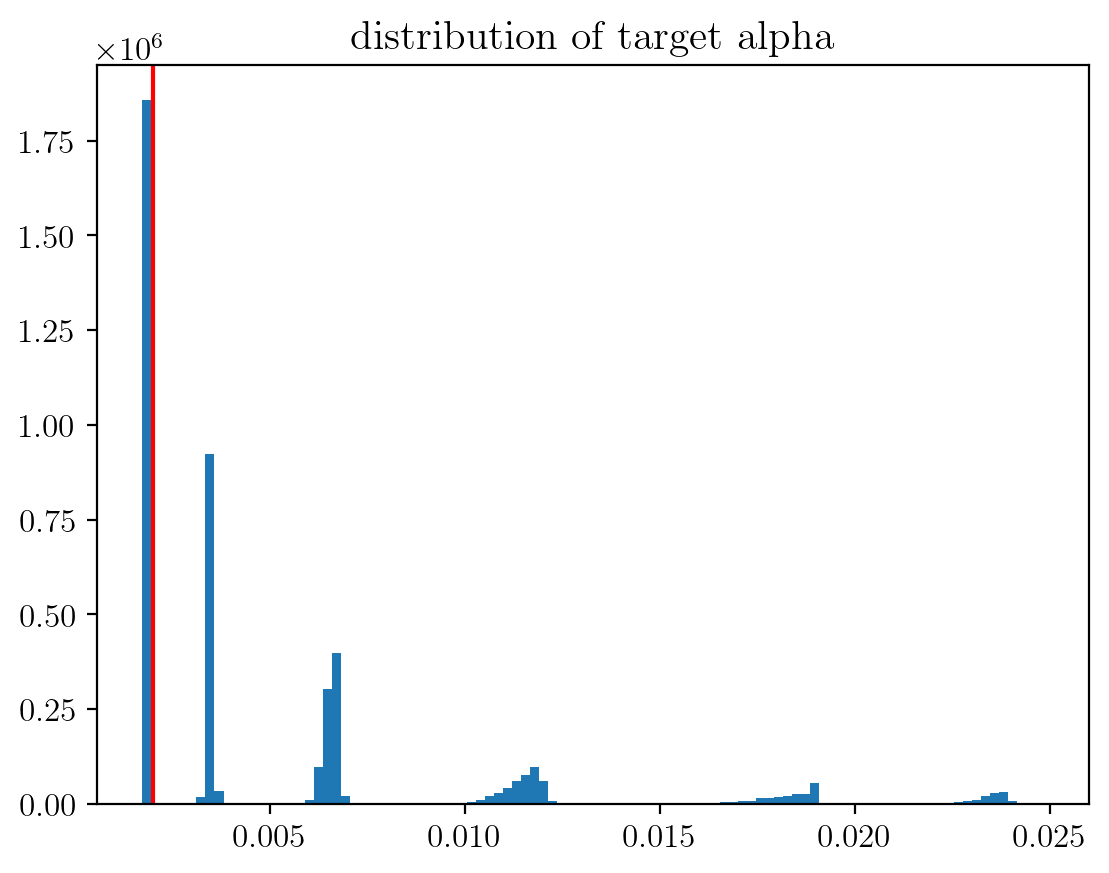

In [132]:
overall_cv = np.min(bootstrap_cvs[:,0])
print('number of tiles near critical: ', np.sum((bootstrap_cvs[:,0] < overall_cv + 0.01)))
print('    and with loose bounds', np.sum((bootstrap_cvs[:,0] < overall_cv + 0.01) & (0.025 - pointwise_target_alpha > 0.002)))
print(f'pct of sim sizes > 2000: {100 * np.mean(sim_sizes > 2000):.1f}%')

plt.title('histogram of critical values')
plt.hist(bootstrap_cvs[:,0], bins=np.linspace(0, 1, 100))
plt.show()

plt.title('distribution of sim sizes')
plt.hist(sim_sizes)
plt.show()

plt.title('distribution of target alpha')
plt.hist(0.025 - pointwise_target_alpha, bins=100)
plt.axvline(0.002, color='r')
plt.show()

In [121]:
ada_step_size = grid_batch_size

In [122]:
cost_to_refine = 2 ** n_arms
sims_required_to_rej_once = 2 / pointwise_target_alpha - 1
cost_to_rej_once = sims_required_to_rej_once / sim_sizes

# if a tile always stops early, it's probably not interesting and we should
# lean towards simulating more rather than more expensive refinement
always_stops_early = bootstrap_cvs[:, 0] >= 1
prefer_simulation = (cost_to_refine > cost_to_rej_once) & (always_stops_early)

alpha_to_rej_once = 2 / (sim_sizes + 1)
impossible = pointwise_target_alpha < alpha_to_rej_once
impossible_refine = impossible & (~prefer_simulation)
impossible_sim = impossible & prefer_simulation

close_to_worst = np.zeros(g.n_tiles, dtype=bool)
# close_to_worst[np.random.choice(np.arange(g.n_tiles), size)] = True
close_to_worst[np.argsort(bootstrap_cvs[:, 0])[:ada_step_size]] = True
close_to_worst[impossible] = False

hob_theory_cost = target_alpha - pointwise_target_alpha
which_refine = close_to_worst & (hob_theory_cost > target_grid_cost)
which_refine |= impossible_refine

bootstrap_min_cvs = np.min(bootstrap_cvs[:, 0:], axis=0)
cv_std = bootstrap_min_cvs.std()
bootstrap_typeI_sum = batched_many_rej(
    sim_sizes[close_to_worst] * 8,
    (np.tile(bootstrap_min_cvs[None, :], (np.sum(close_to_worst), 1)),
    g.theta_tiles[close_to_worst],
    g.null_truth[close_to_worst],),
    (unifs,),
    unifs_order
)
typeI_std = np.zeros(g.n_tiles)
typeI_std[close_to_worst] = (bootstrap_typeI_sum / sim_sizes[close_to_worst, None]).std(axis=1)

running for size 2000 with 64 tiles took 1.3443281650543213


In [129]:
bootstrap_min_cvs

array([0.06411036, 0.00827368, 0.00827368, 0.00139502, 0.00583118, 0.00583118, 0.00139502,
       0.02112997, 0.00139502, 0.00139502, 0.00139502])

In [128]:
bootstrap_min_cvs[0] - bootstrap_min_cvs[1:].mean()

0.058478877496785195

In [123]:
(bootstrap_typeI_sum[:, 0] - (bootstrap_typeI_sum[:, 1:].mean(axis=1))) / sim_sizes[close_to_worst]

array([0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 ,
       0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.0191 ,
       0.0191 , 0.0191 , 0.0191 , 0.0191 , 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125,
       0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125,
       0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125,
       0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125, 0.02125,
       0.02125, 0.02125, 0.02125, 0.02125])

In [97]:
bias = bootstrap_typeI_sum[:,0] - bootstrap_typeI_sum[:, 1:].mean(axis=1)
std = bootstrap_typeI_sum[:, 1:].std(axis=1)
bias, std

(array([39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3,
        39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3, 39.3,
        39.3, 39.3, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9, 38.9,
        38.9, 38.9, 38.9, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4, 39.4,
        39.4, 39.4, 39.4, 39.4]),
 array([3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297,
        3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297,
        3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297,
        3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297, 3.82230297,
        3.82230297, 3.82230297, 3.82230297, 3.82230297, 2.7       , 2.7       , 2.7       ,
        2.7       , 2.7       , 2.7       , 2.7       , 2.7       , 2.7       , 2.7       ,
        2.7       , 2.

In [86]:
bootstrap_typeI_sum[worst_tile]

NameError: name 'worst_tile' is not defined

In [84]:
(bootstrap_typeI_sum / sim_sizes[close_to_worst, None]).std(axis=1)

array([0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 ,
       0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 ,
       0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 ,
       0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 ,
       0.0059356 , 0.0059356 , 0.0059356 , 0.0059356 , 0.00573772, 0.00573772, 0.00573772,
       0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00573772,
       0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00573772, 0.00577147,
       0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147,
       0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147, 0.00577147,
       0.00577147])

In [44]:
key = jax.random.PRNGKey(0)
unifs = jax.random.uniform(key=key, shape=(np.max(sim_sizes),) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

batch_size = 2**4
idxs = np.where(sim_cvs == 0)[0][:batch_size]
overall_cv = 0
simv = jax.jit(
    jax.vmap(lts.sim, in_axes=(None, 0, None, None)), static_argnums=(0,)
)
tunev = jax.jit(jax.vmap(lts.tune, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,))
rejv = jax.jit(
    jax.vmap(lts.rej, in_axes=(None, 0, 0, 0, None, None)), static_argnums=(0,)
)
batched_sim = lts.grouped_by_sim_size(lei_obj, simv, batch_size, n_out=2)
batched_rej = lts.grouped_by_sim_size(lei_obj, rejv, batch_size)
batched_tune = lts.grouped_by_sim_size(lei_obj, tunev, batch_size)

In [49]:
test_stats, best_arms = lts.simv(lei_obj, g.theta_tiles[idxs], unifs[:1000], unifs_order[:1000])

In [69]:
alpha = pointwise_target_alpha[idxs[0]]
cv_idx = jnp.maximum(
    jnp.floor((unifs.shape[0] + 1) * jnp.maximum(alpha, 0)).astype(int) - 1, 0
)
cv_idx

DeviceArray(23, dtype=int64)

In [6]:
sortedts = jnp.sort(test_stats[0])

NameError: name 'test_stats' is not defined

In [41]:
unifs.shape

(1000, 350, 3)

In [39]:
test_stats, best_arm = batched_sim(sim_sizes[idxs], [g.theta_tiles[idxs]], [unifs, unifs_order])

ValueError: shape mismatch: value array of shape (0,1000) could not be broadcast to indexing result of shape (16,1000)

In [ ]:
test_stats.shape

(1000,)

In [ ]:
typeI_sum = batched_sim(
    sim_sizes[idxs],
    np.full(idxs.shape[0], overall_cv),
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    unifs_order,
)